In [1]:
#import packages and formatting statements
import numpy as np
import matplotlib as mpl
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

import sys
sys.path.append('./Python')
from CheckInImage import check_in_image

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

ext = "HA_FLUX_CORR"

In [2]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate

DataFile = '../Data/0.MUSEdata.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, dists =  Data["Galaxy"], Data["Distance"]
maps_1kpc, gal_ra, gal_dec, gal_pa = Data["maps_1kpc"], Data["Gal_ra"], Data["Gal_dec"], Data["Pos_ang"]
MUSE_res, maps_150, maps_HII, maps_irac,incls = Data["MUSE_nat_res"], Data["maps_150"], Data["maps_HII"], Data["maps_irac"], Data["Incl"]
maps_nat,maps_CO21,maps_eCO21 = Data["maps_nat"],Data["maps_CO21"],Data["maps_eCO21"]
SNe, types = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = (0,1))
ras, decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=(5,6))


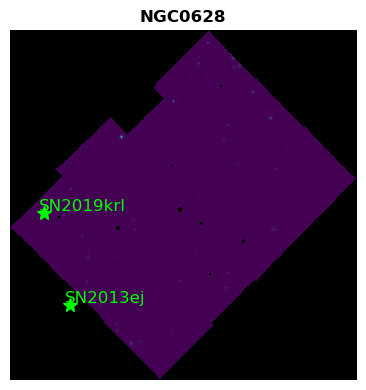

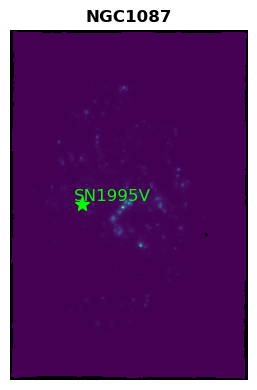

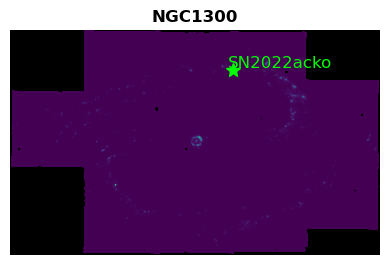

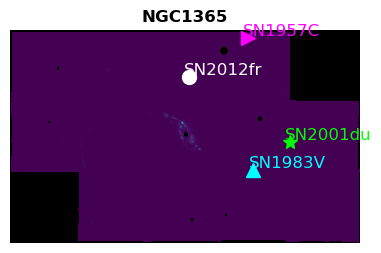

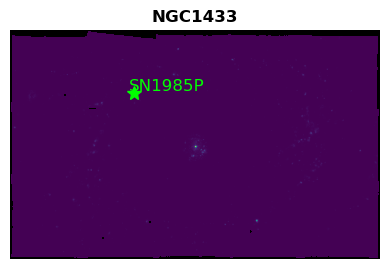

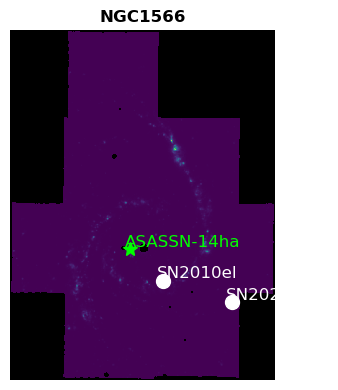

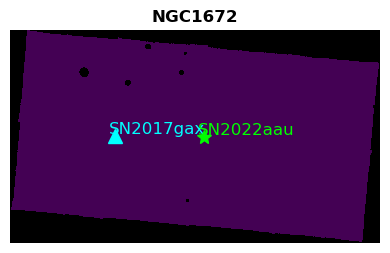

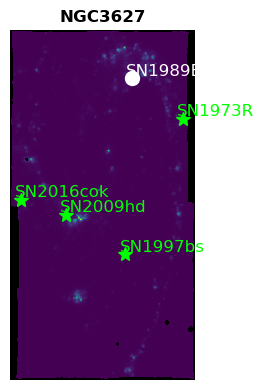

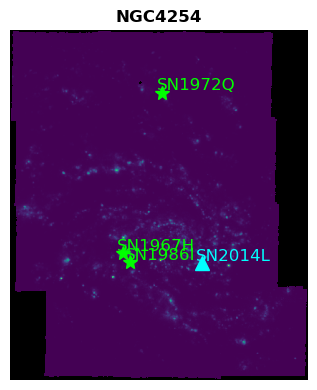

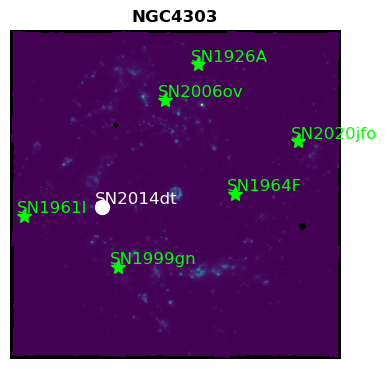

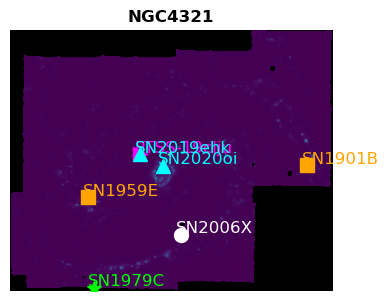

In [3]:
# Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint
# exploratory plotting: galaxies with SNe 

gals, sne_names, sne_types, sne_ra, sne_dec = [],[],[],[],[]

for i in range(len(maps_nat)):
    sn_name, sn_type, sn_ra, sn_dec, map, x_coord, y_coord = check_in_image(ras, decs, SNe, types, maps_nat[i], ext=ext)
    
    # plot SNe and add their info that are found within footprint to list
    if len(sn_name) > 0:
        
        plt.figure(figsize=(4, 4))                             # set up plot
        cmap = mpl.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
        cmap.set_bad(color='black')
        plt.imshow(map, origin='lower', interpolation='nearest', zorder=1, cmap=cmap)
        
        for j in range(len(sn_name)):                      # get lists of SNe info
            gals.append(galaxies[i])
            sne_names.append(sn_name[j])
            sne_types.append(sn_type[j])
            sne_ra.append(sn_ra[j])
            sne_dec.append(sn_dec[j])  
            
            string = sn_name[j]                            # get rest of plot info

            if (len(sn_type[j])>1):
                if sn_type[j][1] == "I":
                    colorCode = 'lime'
                    mkr = '*'
                elif sn_type[j][1] == "b" or sn_type[j][1] == "c":
                    colorCode = 'cyan'
                    mkr = '^'
                elif sn_type[j][1] == "a":
                    colorCode = 'white'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                colorCode = 'orange'
                mkr='s'

            plt.plot(x_coord[j], y_coord[j], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[j]-20, y_coord[j]+8, string, fontsize=12, color=colorCode)
            
        plt.axis('off')
        plt.title(galaxies[i], fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        plt.close()


In [4]:
# filter out undesired OSC entries:
# One is a double counted SN named "PTSS-19clju", any LRNs or LBVs, and any candidates
flags = []

for i in range(len(sne_names)):
    if ("LRN" in sne_types[i] or "LBV" in sne_types[i] or "Candidate" in sne_types[i] or "PTSS-19clju" in 
       sne_names[i] or "Gaia21fml" in sne_names[i] or "Gaia21cum" in sne_names[i] or "SN2013ej" in sne_names[i]
       or "SN1979C" in sne_names[i]):
        flags.append(False)
    else:
        flags.append(True)

# put SN data in table and write to file
results = Table({"Galaxy"  : gals,
                "Supernova": sne_names,
                "Type"     : sne_types,
                "SN_ra"    : sne_ra,
                "SN_dec"   : sne_dec,
                "In_Sample": flags})

# write all objects into all_objects file for latex table
results.write("../Data/1.MUSE_All_Objects.csv", format = "csv", overwrite = True)

# apply mask and write cleaned sample to file
mask = results["In_Sample"] == True
cleanData = results[mask]

cleanData.write("../Data/1.MUSE_SN_Sample.csv", format = "csv", overwrite = True)
cleanData[0:1]


<Table length=1>
 Galaxy Supernova  Type       SN_ra              SN_dec       In_Sample
  str7    str11   str12      float64            float64          bool  
------- --------- ----- ----------------- ------------------- ---------
NGC1087   SN1995V    II 41.61152777777777 -0.4987861111111111      True

In [5]:
# join databases to plot SNe on galaxy maps 
data = join(Data, cleanData, keys = "Galaxy", join_type = 'inner')
data[0:1]

<Table length=1>
 Galaxy Distance  Gal_ra  ...       SN_ra              SN_dec       In_Sample
  str7  float64  float64  ...      float64            float64          bool  
------- -------- -------- ... ----------------- ------------------- ---------
NGC1087    15.85 41.60492 ... 41.61152777777777 -0.4987861111111111      True

In [6]:
#Group SN data by galaxy and save to new database

gal_groups = data.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()

#galaxies info
galaxies, dists, gal_ra, gal_dec, gal_pa, incls, MUSE_res = [],[],[],[],[],[],[]

# maps info                          
maps_nat, maps_150, maps_1kpc, maps_HII, maps_irac, maps_CO21, maps_eCO21 = [],[],[],[],[],[],[]                           

# SN info
sn_name, sn_type, sn_ra, sn_dec = [],[],[],[]

for i in range(len(indices)-1):
    
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]               # columns that may have more than one entry    
    
    dists.append(gal_groups["Distance"][indices[i]])
    gal_ra.append(gal_groups["Gal_ra"][indices[i]])
    gal_dec.append(gal_groups["Gal_dec"][indices[i]])
    gal_pa.append(gal_groups["Pos_ang"][indices[i]])
    incls.append(gal_groups["Incl"][indices[i]])
    MUSE_res.append(gal_groups["MUSE_nat_res"][indices[i]])
    
    maps_nat.append(gal_groups["maps_nat"][indices[i]])
    maps_150 .append(gal_groups["maps_150"][indices[i]])
    maps_1kpc.append(gal_groups["maps_1kpc"][indices[i]])
    maps_HII.append(gal_groups["maps_HII"][indices[i]])
    maps_irac.append(gal_groups["maps_irac"][indices[i]])
    maps_CO21.append(gal_groups["maps_CO21"][indices[i]])
    maps_eCO21.append(gal_groups["maps_eCO21"][indices[i]])
    
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["SN_ra"][indices[i]])
    SNdecs.append(gal_groups["SN_dec"][indices[i]])
    j = 1
    
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["SN_ra"][indices[i]+j])
        SNdecs.append(gal_groups["SN_dec"][indices[i]+j])
        j += 1
    
    if len(SNnames) != 0:
        sn_name.append(SNnames)
        sn_type.append(SNtypes)
        sn_ra.append(SNras)
        sn_dec.append(SNdecs)
        galaxies.append(gals[i][0])
        
grouped_data = pd.DataFrame({"galaxy"  : galaxies,
                           "distance"  : dists,
                           "gal_ra"    : gal_ra,
                           "gal_dec"   : gal_dec,
                           "pos_ang"   : gal_pa,
                           "incl"      : incls,
                           "nat_res"   : MUSE_res,
                           "maps_nat"  : maps_nat,
                           "maps_150"  : maps_150,
                           "maps_1kpc" : maps_1kpc,
                           "maps_HII"  : maps_HII,
                           "maps_irac" : maps_irac,
                           "maps_CO21" : maps_CO21,
                           "maps_eCO21": maps_eCO21,                             
                           "sn_name"   : sn_name,
                           "sn_type"   : sn_type,
                           "sn_ra"     : sn_ra,
                           "sn_dec"    : sn_dec})


In [7]:
grouped_data.to_csv("../Data/1.GroupedSampleData.csv")
grouped_data[0:1]


galaxy  distance    gal_ra   gal_dec  pos_ang  incl  nat_res  \
0  NGC1087     15.85  41.60492 -0.498717    359.1  42.9     0.92   

                                            maps_nat  \
0  ../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...   

                                            maps_150  \
0  ../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...   

                                           maps_1kpc  \
0  ../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...   

                                            maps_HII  \
0  ../Data/HII_reg_masks/NGC1087_nebulae_mask_V2....   

                                  maps_irac  \
0  ../Data/IRAC/ngc1087_irac1_atGauss4.fits   

                                           maps_CO21  \
0  ../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...   

                                          maps_eCO21    sn_name sn_type  \
0  ../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...  [SN1995V]    [II]   

                 sn_ra                 sn_dec  
0  [41.61152777777777]  [-0.4987861111111111]

In [8]:

# set up multi panel galaxy + SN plot for paper
SNgals, plots, wcss, legendLabels, HII_regs = [],[],[],[],[]

for i in range(len(galaxies)):
        
    if os.path.isfile(maps_nat[i]):
        SNgals.append(galaxies[i])
        hdu = pyfits.open(maps_nat[i])
        img_map = hdu[ext].data
        plots.append(img_map)
        w = WCS(hdu[ext].header, naxis=2)
        wcss.append(w)
        
        hdu_HII = pyfits.open(maps_HII[i])
        map_HII = hdu_HII[0].data
        HII_regs.append(map_HII)
        
        legendlabel = []
        if len(sn_name[i]) > 1:
            for k in range(len(sn_name[i])):
                if sn_type[i][k] == 'Unclassified':
                    typelabel = sn_name[i][k] + ' '  + sn_type[i][k]
                else:
                    typelabel = sn_name[i][k] + ' Type '  + sn_type[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(sn_name[i][0] + ' '  + sn_type[i][0]) 
            else:        
                legendlabel.append(sn_name[i][0] + ' Type '  + sn_type[i][0])
        legendLabels.append(legendlabel)
        

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_16520/2766197836.py:16: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[q])


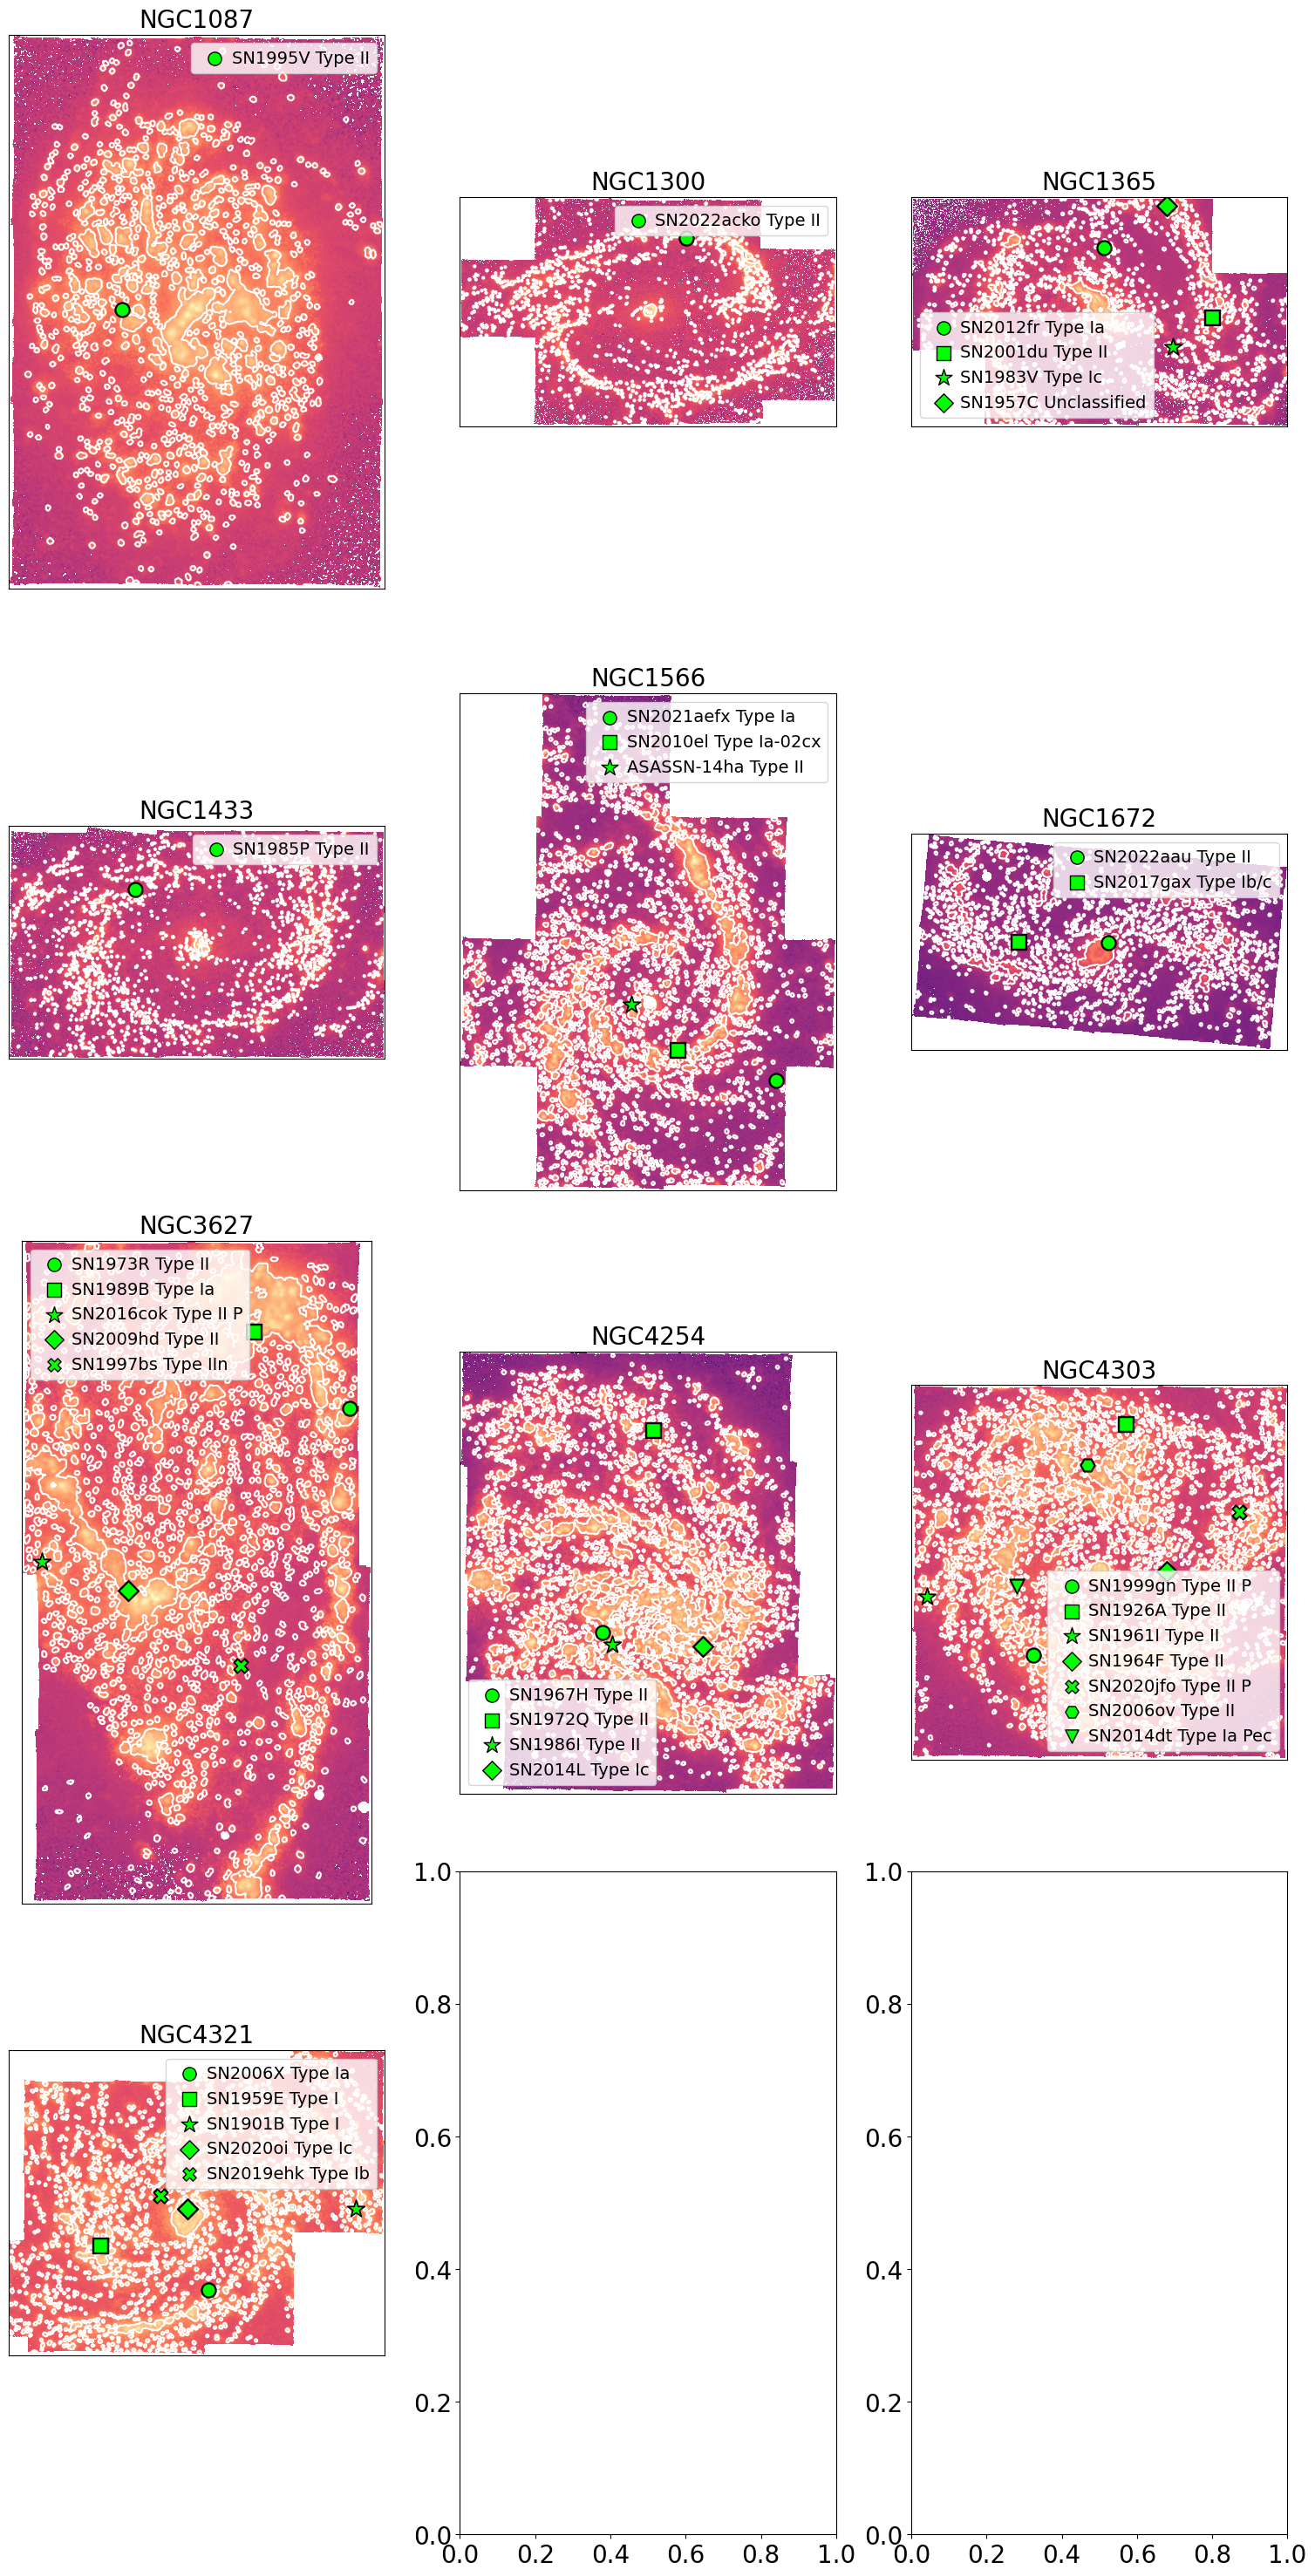

In [9]:
# set up multi panel galaxy + SN plot for paper
markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("white")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 30))

for q in range(len(plots)):

    xArr, yArr = wcss[m].wcs_world2pix(sn_ra[m],sn_dec[m],0)
    logplot = np.log10(plots[q])
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].contour(HII_regs[q],[-1], colors = ["white"], linestyles = ("-"), zorder = 1)
    for n in range(len(sn_dec[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/MUSEGalaxiesHII.pdf", dpi=300)
   

print()